In [3]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [4]:
# Add project directory to path
import os
import sys
sys.path.append(os.path.abspath(".."))

# Import custom modules
from src.data.data_ingestion import DataIngestion, DataIngestionConfig
from src.data.data_preprocessing import DataPreprocessing
from src.backtesting.backtest_engine import BacktestEngine
from src.backtesting.performance_metrics import PerformanceMetrics
from src.backtesting.visualization import VisualizationTools
from src.strategies.pairs_trading import PairsTrading
from src.utils.logger import get_logger


In [5]:
# Initialize logger
logger = get_logger("backtesting_notebook")
logger.info("Starting backtesting process")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Load processed data and signal results
logger.info("Loading data and signal results")



[ 2025-05-11 20:14:04,170 ] 3 backtesting_notebook - INFO - Starting backtesting process
[ 2025-05-11 20:14:04,172 ] 10 backtesting_notebook - INFO - Loading data and signal results


In [7]:
custom_config = DataIngestionConfig()
# Fix the path - go up one level from notebooks directory
custom_config.project_root = os.path.dirname(os.getcwd())  
custom_config.raw_data_path = os.path.join(custom_config.project_root, 'data', 'raw', 'Portfolio_prices.csv')
custom_config.processed_data_dir = os.path.join(custom_config.project_root, 'data', 'processed')
data_preprocessor = DataPreprocessing()

# Use the existing DataIngestion class with our fixed config
data_ingestion = DataIngestion(config=custom_config)
processed_df = data_preprocessor.preprocess_data(raw_df)

raw_df = data_ingestion.read_data()

print(f"Dataset shape: {raw_df.shape}")
raw_df.head()

[ 2025-05-11 20:14:34,509 ] 47 src.data.data_ingestion - INFO - Raw data path: d:\projects\Relative-Value-Analysis-Pairs-Trading\data\raw\Portfolio_prices.csv
[ 2025-05-11 20:14:34,509 ] 48 src.data.data_ingestion - INFO - File exists: True
[ 2025-05-11 20:14:34,511 ] 185 src.data.data_preprocessing - INFO - Starting data preprocessing
[ 2025-05-11 20:14:34,512 ] 82 src.data.data_preprocessing - INFO - Converting Date to datetime format
[ 2025-05-11 20:14:34,521 ] 87 src.data.data_preprocessing - INFO - Successfully converted Date to datetime format
[ 2025-05-11 20:14:34,521 ] 108 src.data.data_preprocessing - INFO - Handling missing values
[ 2025-05-11 20:14:34,526 ] 112 src.data.data_preprocessing - INFO - Missing values before handling: Date        0
Ticker      0
Open        0
High        0
Low         0
Close       0
Adjusted    0
Returns     0
Volume      0
dtype: int64
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\data\data_preprocessing.py:116: FutureWarning: DataFrame.

Dataset shape: (35397, 9)


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-03,JPM,137.500000,139.229996,137.080002,138.339996,119.874138,-0.013197,10386800
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,46.494698,-0.005455,11354500
2,2020-01-03,LMT,404.019989,417.170013,403.000000,413.739990,359.312317,0.035981,2990100
3,2020-01-03,MS,51.220001,51.450001,50.830002,51.200001,43.273079,-0.016142,6706000
4,2020-01-03,MSCI,262.200012,263.579987,259.269989,260.750000,248.019470,-0.019921,459700


In [8]:
# Path to signals directory
signals_dir = os.path.join('..', 'data', 'processed', 'signals')


In [9]:
# Load performance summary
performance_summary_path = os.path.join(signals_dir, "performance_summary.csv")
if os.path.exists(performance_summary_path):
    performance_df = pd.read_csv(performance_summary_path)
    logger.info(f"Loaded performance summary for {len(performance_df)} pairs")
    display(performance_df.head())
else:
    logger.error("Performance summary file not found. Cannot proceed with backtesting.")
    raise FileNotFoundError("Performance summary file not found. Run the trading signals notebook first.")


[ 2025-05-11 20:14:45,843 ] 5 backtesting_notebook - INFO - Loaded performance summary for 11 pairs


,Pair,TotalSignals,TotalReturn,AnnualizedVolatility,SharpeRatio,MaxDrawdown,WinRate,AvgWin,AvgLoss,ProfitFactor,ReturnToDrawdown
0,AAPL-CAT,248,3.874713,0.765384,0.710750,-0.674485,0.532258,0.101601,-0.066820,1.730233,5.744696
1,AAPL-PG,212,0.442997,0.113679,0.676967,-0.131725,0.613208,0.018514,-0.019586,1.498562,3.363047
2,IBKR-TMUS,268,1.050875,0.752905,0.407511,-0.404162,0.492537,0.064220,-0.038858,1.604072,2.600130
3,PG-SPY,198,0.425240,0.126384,0.600524,-0.206722,0.515152,0.023415,-0.016652,1.493977,2.057066
4,CSCO-MS,198,0.282597,0.117022,0.465903,-0.139526,0.457627,0.020800,-0.013119,1.337831,2.025415


In [10]:
# 2. Set up backtest parameters
logger.info("Setting up backtest parameters")


[ 2025-05-11 20:14:51,004 ] 2 backtesting_notebook - INFO - Setting up backtest parameters


In [11]:
# Backtest parameters
initial_capital = 100000.0  # Initial capital
transaction_cost = 0.001    # 0.1% per trade
slippage = 0.0005           # 0.05% slippage
risk_per_trade = 0.02       # 2% of capital per trade
position_sizing = 'equal'   # Equal position sizing for each pair


In [12]:
# Date range for backtesting
start_date = processed_df['Date'].min()
end_date = processed_df['Date'].max()
print(f"Backtest period: {start_date} to {end_date}")


Backtest period: 2020-01-03 00:00:00 to 2025-03-21 00:00:00


In [13]:
# Strategy parameters
strategy_params = {
    'lookback_period': 60,
    'entry_threshold': 2.0,
    'exit_threshold': 0.5,
    'stop_loss': 3.0,
    'max_holding_period': 20,
    'position_size': risk_per_trade
}


In [14]:
# Initialize backtest engine
backtest_engine = BacktestEngine(
    initial_capital=initial_capital,
    transaction_cost=transaction_cost,
    slippage=slippage,
    price_col='Adjusted'
)


[ 2025-05-11 20:15:05,688 ] 51 BacktestEngine - INFO - Initialized BacktestEngine with capital=100000.0, transaction_cost=0.001, slippage=0.0005


In [15]:
# Initialize performance metrics calculator
metrics_calculator = PerformanceMetrics()


[ 2025-05-11 20:15:11,044 ] 30 PerformanceMetrics - INFO - Initialized PerformanceMetrics with annualization_factor=252


In [16]:
# Initialize visualization tools
viz_tools = VisualizationTools()



[ 2025-05-11 20:15:14,177 ] 40 VisualizationTools - INFO - Initialized VisualizationTools with style=seaborn-v0_8-darkgrid, figsize=(12, 8)


In [17]:
# 3. Prepare pairs for backtesting
logger.info("Preparing pairs for backtesting")



[ 2025-05-11 20:15:17,845 ] 2 backtesting_notebook - INFO - Preparing pairs for backtesting


In [18]:
# Select top performing pairs based on Sharpe ratio
top_n_pairs = min(5, len(performance_df))
selected_pairs = performance_df.head(top_n_pairs)
print(f"Selected {len(selected_pairs)} pairs for backtesting:")
display(selected_pairs[['Pair', 'TotalReturn', 'SharpeRatio', 'WinRate', 'ProfitFactor']])


Selected 5 pairs for backtesting:


,Pair,TotalReturn,SharpeRatio,WinRate,ProfitFactor
0,AAPL-CAT,3.874713,0.710750,0.532258,1.730233
1,AAPL-PG,0.442997,0.676967,0.613208,1.498562
2,IBKR-TMUS,1.050875,0.407511,0.492537,1.604072
3,PG-SPY,0.425240,0.600524,0.515152,1.493977
4,CSCO-MS,0.282597,0.465903,0.457627,1.337831


In [19]:
# Format pairs for backtest engine
pairs_to_test = []
for idx, row in selected_pairs.iterrows():
    pair = row['Pair']
    ticker1, ticker2 = pair.split('-')
    pairs_to_test.append((ticker1, ticker2))



In [20]:
# 4. Run backtest for individual pairs
logger.info("Running backtest for individual pairs")


[ 2025-05-11 20:15:33,351 ] 2 backtesting_notebook - INFO - Running backtest for individual pairs


In [21]:
# Store individual pair results
individual_pair_results = {}



In [22]:
for pair in pairs_to_test:
    ticker1, ticker2 = pair
    pair_name = f"{ticker1}-{ticker2}"
    
    logger.info(f"Backtesting pair {pair_name}")
    
    # Prepare data for this pair only
    pair_data = processed_df[processed_df['Ticker'].isin([ticker1, ticker2])]
    
    # Run backtest for this pair
    result = backtest_engine.run_backtest(
        price_data=pair_data,
        pairs=[pair],
        strategy_params=strategy_params,
        start_date=start_date,
        end_date=end_date
    )
    
    # Store the results
    individual_pair_results[pair_name] = result
    
    # Print summary
    pair_return = result['final_return']
    pair_sharpe = result['sharpe_ratio']
    pair_drawdown = result['max_drawdown']
    
    print(f"Pair {pair_name}: Return: {pair_return:.2%}, Sharpe: {pair_sharpe:.2f}, Max Drawdown: {pair_drawdown:.2%}")



[ 2025-05-11 20:15:42,845 ] 5 backtesting_notebook - INFO - Backtesting pair AAPL-CAT
[ 2025-05-11 20:15:42,848 ] 141 BacktestEngine - INFO - Starting backtest with 1 pairs
[ 2025-05-11 20:15:42,849 ] 71 BacktestEngine - INFO - Preparing price data for backtesting
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\backtesting\backtest_engine.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Date'] = pd.to_datetime(price_data['Date'])
[ 2025-05-11 20:15:42,877 ] 89 BacktestEngine - INFO - Filtered price data for 2 tickers
[ 2025-05-11 20:15:42,881 ] 108 BacktestEngine - INFO - Prepared data for 2 tickers from 2020-01-03 00:00:00 to 2025-03-21 00:00:00
[ 2025-05-11 20:15:42,881 ] 44 PairsTrading - INFO - Initialized PairsTrading s

Pair AAPL-CAT: Return: -2.09%, Sharpe: -2.62, Max Drawdown: -2.09%
Pair AAPL-PG: Return: -2.40%, Sharpe: -2.34, Max Drawdown: -2.40%


[ 2025-05-11 20:15:43,187 ] 250 PairsTrading - INFO - Backtest completed with final return: -0.0524
[ 2025-05-11 20:15:43,243 ] 222 BacktestEngine - INFO - Completed backtest for pair IBKR-TMUS
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\backtesting\backtest_engine.py:225: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.portfolio_value.fillna(method='ffill', inplace=True)
[ 2025-05-11 20:15:43,246 ] 240 BacktestEngine - INFO - Backtest completed with final return: -0.0262, Sharpe ratio: -2.1814, Max drawdown: -0.0262
[ 2025-05-11 20:15:43,247 ] 5 backtesting_notebook - INFO - Backtesting pair PG-SPY
[ 2025-05-11 20:15:43,249 ] 141 BacktestEngine - INFO - Starting backtest with 1 pairs
[ 2025-05-11 20:15:43,251 ] 71 BacktestEngine - INFO - Preparing price data for backtesting
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\backtesting\backtest_engine.py:83: SettingWithCopyWarning:

Pair IBKR-TMUS: Return: -2.62%, Sharpe: -2.18, Max Drawdown: -2.62%
Pair PG-SPY: Return: -0.72%, Sharpe: -6.78, Max Drawdown: -0.72%


[ 2025-05-11 20:15:43,436 ] 250 PairsTrading - INFO - Backtest completed with final return: -0.0234
[ 2025-05-11 20:15:43,488 ] 222 BacktestEngine - INFO - Completed backtest for pair CSCO-MS
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\backtesting\backtest_engine.py:225: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.portfolio_value.fillna(method='ffill', inplace=True)
[ 2025-05-11 20:15:43,491 ] 240 BacktestEngine - INFO - Backtest completed with final return: -0.0117, Sharpe ratio: -4.3383, Max drawdown: -0.0117


Pair CSCO-MS: Return: -1.17%, Sharpe: -4.34, Max Drawdown: -1.17%


In [24]:

# 5. Run portfolio backtest (combining all pairs)
logger.info("Running portfolio backtest")

[ 2025-05-11 20:15:50,958 ] 2 backtesting_notebook - INFO - Running portfolio backtest


In [25]:
# Run backtest for all pairs combined
portfolio_results = backtest_engine.run_backtest(
    price_data=processed_df,
    pairs=pairs_to_test,
    strategy_params=strategy_params,
    start_date=start_date,
    end_date=end_date
)


[ 2025-05-11 20:15:57,922 ] 141 BacktestEngine - INFO - Starting backtest with 5 pairs
[ 2025-05-11 20:15:57,924 ] 71 BacktestEngine - INFO - Preparing price data for backtesting
[ 2025-05-11 20:15:57,935 ] 89 BacktestEngine - INFO - Filtered price data for 10 tickers
[ 2025-05-11 20:15:57,952 ] 108 BacktestEngine - INFO - Prepared data for 8 tickers from 2020-01-03 00:00:00 to 2025-03-21 00:00:00
[ 2025-05-11 20:15:57,953 ] 44 PairsTrading - INFO - Initialized PairsTrading strategy with parameters: lookback_period=60, entry_threshold=2.0, exit_threshold=0.5, stop_loss=3.0, max_holding_period=20, position_size=0.02
[ 2025-05-11 20:15:57,966 ] 183 BacktestEngine - INFO - Backtest period: 2020-01-03 00:00:00 to 2025-03-21 00:00:00 (1311 days)
[ 2025-05-11 20:15:57,979 ] 76 PairsTrading - INFO - Calculated hedge ratio: 0.49459560645452777
[ 2025-05-11 20:15:58,018 ] 191 PairsTrading - INFO - Generated signals with 124 active positions
[ 2025-05-11 20:15:58,020 ] 250 PairsTrading - INFO - 

In [26]:
# Print portfolio summary
portfolio_return = portfolio_results['final_return']
portfolio_sharpe = portfolio_results['sharpe_ratio']
portfolio_drawdown = portfolio_results['max_drawdown']


In [27]:
print(f"\nPortfolio Performance:")
print(f"Total Return: {portfolio_return:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe:.2f}")
print(f"Maximum Drawdown: {portfolio_drawdown:.2%}")




Portfolio Performance:
Total Return: -1.17%
Sharpe Ratio: -4.34
Maximum Drawdown: -1.17%


In [28]:
# 6. Calculate detailed performance metrics
logger.info("Calculating detailed performance metrics")


[ 2025-05-11 20:16:10,546 ] 2 backtesting_notebook - INFO - Calculating detailed performance metrics


In [29]:
# Calculate detailed metrics for the portfolio
portfolio_metrics = metrics_calculator.calculate_all_metrics(
    portfolio_results['portfolio_value'],
    portfolio_results['portfolio_returns'],
    trades=portfolio_results['trades']
)


[ 2025-05-11 20:16:14,065 ] 476 PerformanceMetrics - INFO - Calculating all performance metrics
[ 2025-05-11 20:16:14,071 ] 533 PerformanceMetrics - INFO - Successfully calculated all performance metrics


In [30]:
# Print detailed metrics
print("\nDetailed Portfolio Performance Metrics:")
for key, value in portfolio_metrics.items():
    if key != 'drawdown_details':
        if isinstance(value, float):
            if key in ['total_return', 'annualized_return', 'volatility', 'max_drawdown', 'win_rate']:
                print(f"{key}: {value:.2%}")
            else:
                print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")



Detailed Portfolio Performance Metrics:
total_return: -1.17%
annualized_return: -0.23%
volatility: 0.51%
sharpe_ratio: -0.4388
sortino_ratio: -0.0121
max_drawdown: -1.17%
calmar_ratio: -0.1924
win_rate: 46.91%
profit_factor: 0.9860
average_win: 1.8658
average_loss: -1.6722
win_loss_ratio: 1.1158
value_at_risk_95: 0.0000
expected_shortfall_95: -0.0002
skewness: -36.1525
kurtosis: 1305.0008


In [31]:
# 7. Visualize backtest results
logger.info("Visualizing backtest results")


[ 2025-05-11 20:16:23,529 ] 2 backtesting_notebook - INFO - Visualizing backtest results


[ 2025-05-11 20:16:29,648 ] 64 VisualizationTools - INFO - Plotting equity curve with title 'Pairs Trading Strategy Equity Curve'


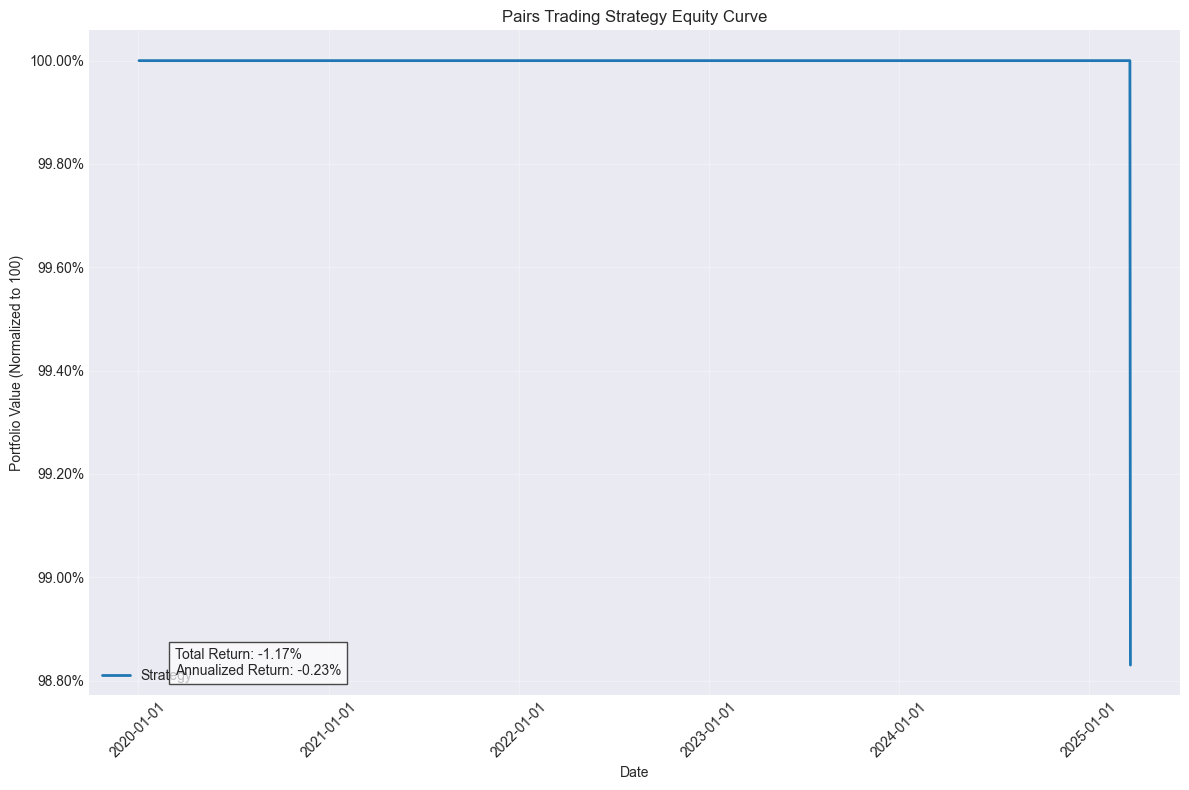

In [32]:
# 7.1. Create equity curve plot
equity_curve_fig = viz_tools.plot_equity_curve(
    portfolio_results['portfolio_value'],
    title='Pairs Trading Strategy Equity Curve'
)
plt.show()


[ 2025-05-11 20:16:34,283 ] 159 VisualizationTools - INFO - Plotting drawdowns with title 'Pairs Trading Strategy Drawdowns'


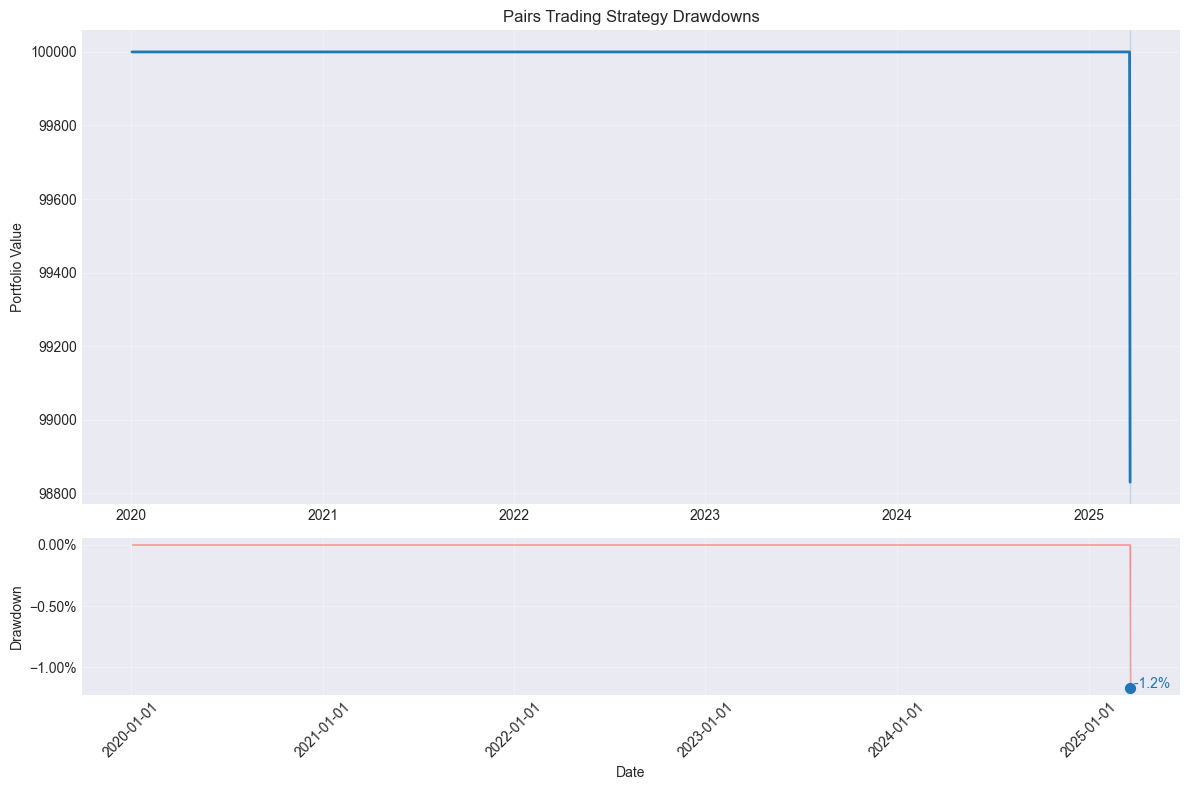

In [33]:
# 7.2. Create drawdowns plot
drawdowns_fig = viz_tools.plot_drawdowns(
    portfolio_results['portfolio_value'],
    title='Pairs Trading Strategy Drawdowns'
)
plt.show()


[ 2025-05-11 20:16:38,663 ] 274 VisualizationTools - INFO - Plotting returns distribution with title 'Pairs Trading Strategy Returns Distribution'


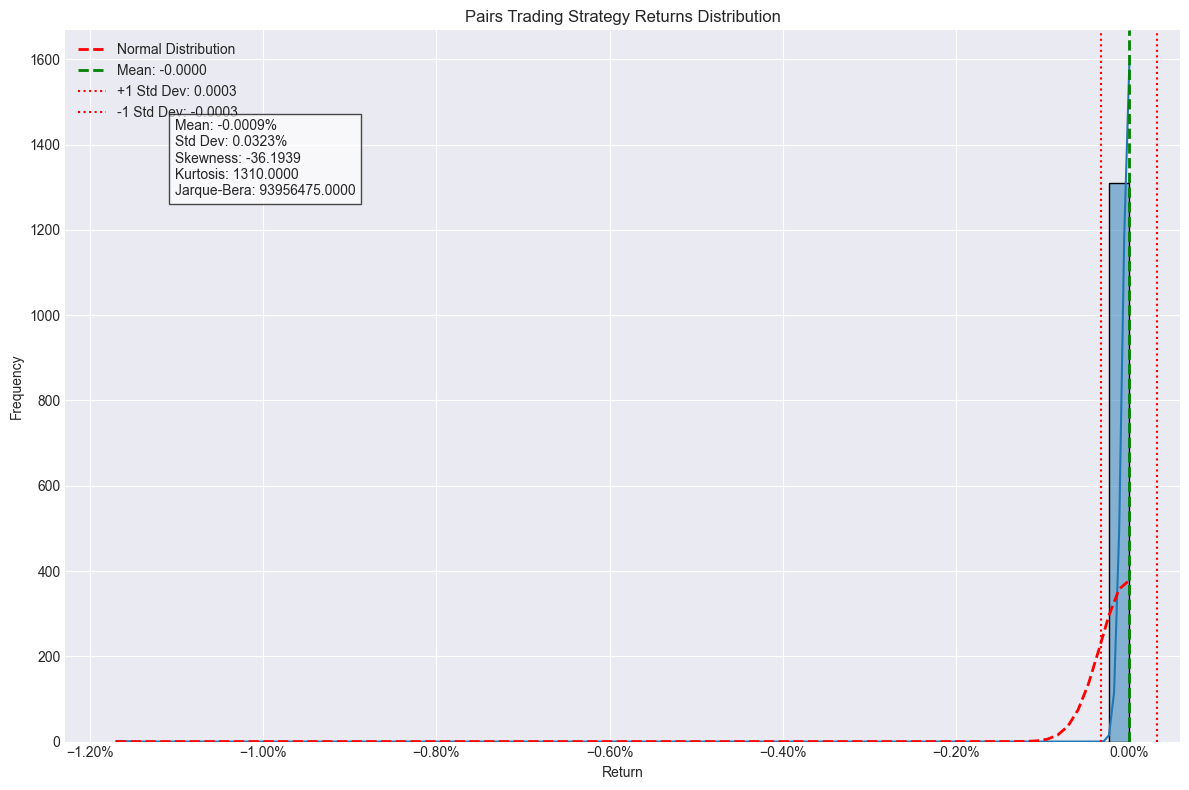

In [34]:
# 7.3. Create returns distribution plot
returns_dist_fig = viz_tools.plot_returns_distribution(
    portfolio_results['portfolio_returns'],
    title='Pairs Trading Strategy Returns Distribution'
)
plt.show()



[ 2025-05-11 20:16:42,932 ] 467 VisualizationTools - INFO - Plotting performance metrics with title 'Pairs Trading Strategy Performance Metrics'


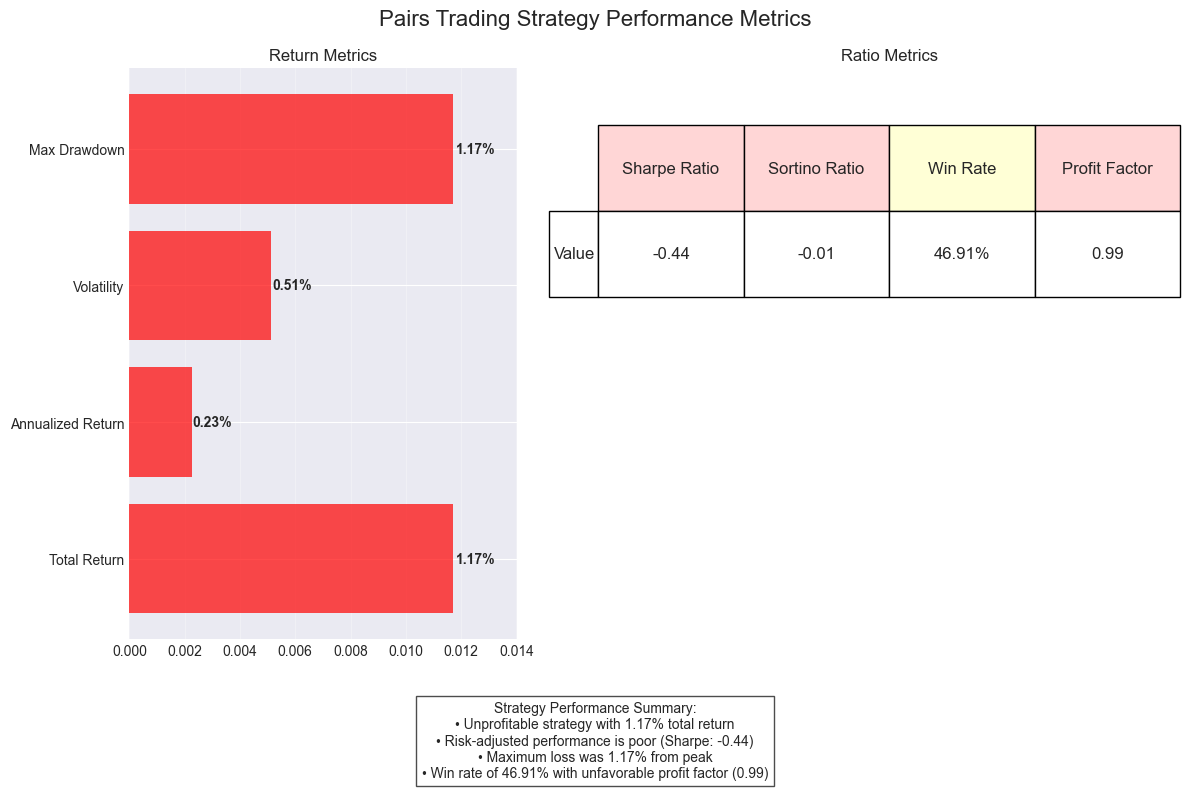

In [35]:
# 7.4. Create performance metrics plot
metrics_fig = viz_tools.plot_performance_metrics(
    portfolio_metrics,
    title='Pairs Trading Strategy Performance Metrics'
)
plt.show()


In [36]:
# 7.5. Compare individual pair performance
# Prepare data for comparison
pair_comparison_data = []
for pair_name, result in individual_pair_results.items():
    pair_comparison_data.append({
        'Pair': pair_name,
        'Return': result['final_return'],
        'Sharpe': result['sharpe_ratio'],
        'MaxDrawdown': result['max_drawdown']
    })


In [37]:
# Add portfolio results for comparison
pair_comparison_data.append({
    'Pair': 'Portfolio',
    'Return': portfolio_return,
    'Sharpe': portfolio_sharpe,
    'MaxDrawdown': portfolio_drawdown
})


In [38]:
pair_comparison_df = pd.DataFrame(pair_comparison_data)


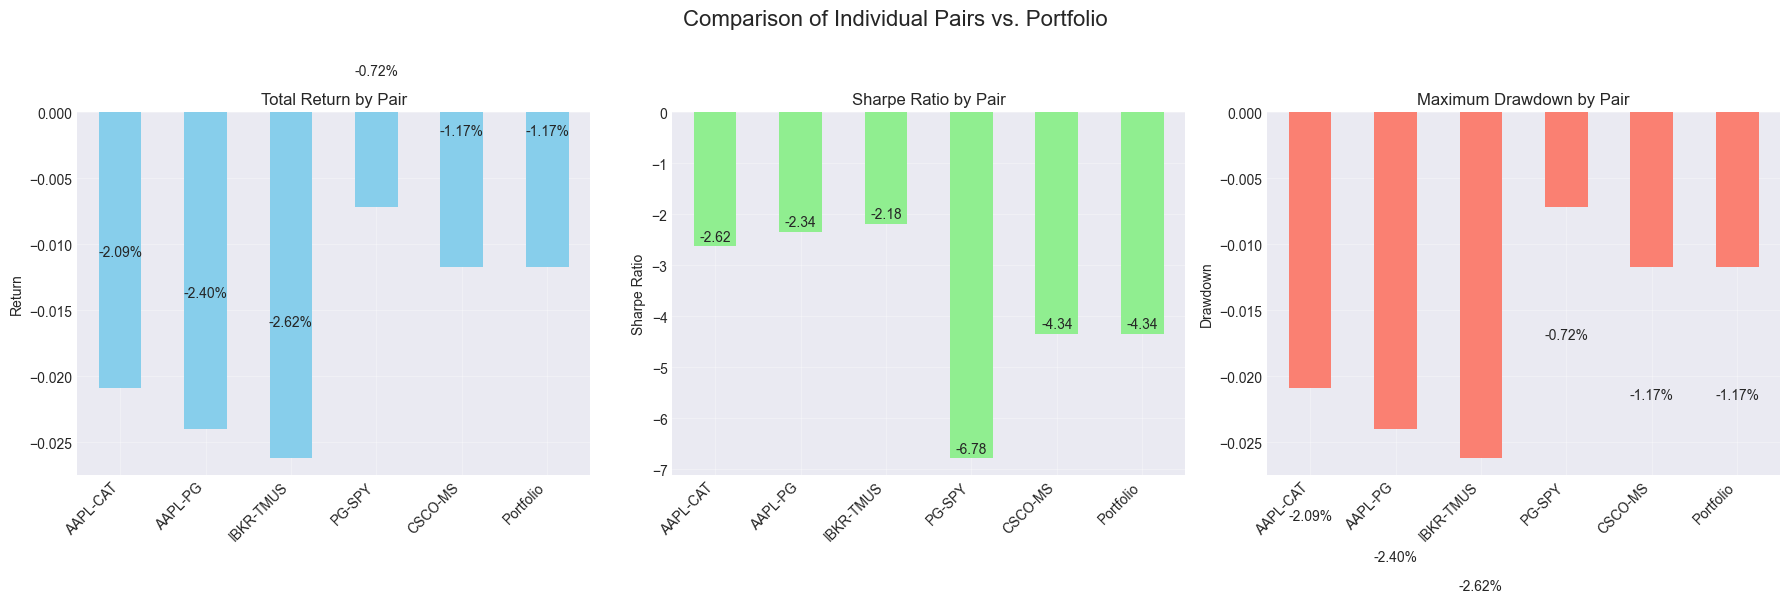

In [39]:
# Plot comparison of metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Plot returns
pair_comparison_df['Return'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Total Return by Pair')
axes[0].set_ylabel('Return')
axes[0].set_xticklabels(pair_comparison_df['Pair'], rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(pair_comparison_df['Return']):
    axes[0].text(i, v + 0.01, f'{v:.2%}', ha='center')

# Plot Sharpe ratio
pair_comparison_df['Sharpe'].plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Sharpe Ratio by Pair')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_xticklabels(pair_comparison_df['Pair'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(pair_comparison_df['Sharpe']):
    axes[1].text(i, v + 0.1, f'{v:.2f}', ha='center')

# Plot drawdown
pair_comparison_df['MaxDrawdown'].plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('Maximum Drawdown by Pair')
axes[2].set_ylabel('Drawdown')
axes[2].set_xticklabels(pair_comparison_df['Pair'], rotation=45, ha='right')
axes[2].grid(True, alpha=0.3)
for i, v in enumerate(pair_comparison_df['MaxDrawdown']):
    axes[2].text(i, v - 0.01, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.suptitle('Comparison of Individual Pairs vs. Portfolio', fontsize=16, y=1.05)
plt.show()



In [40]:
# 8. Analyze the trades
logger.info("Analyzing trades")


[ 2025-05-11 20:17:13,988 ] 2 backtesting_notebook - INFO - Analyzing trades



Trade Analysis:
Total Number of Trades: 567
Winning Trades: 266 (46.91%)
Losing Trades: 301 (53.09%)
Average Winning Trade: $1.87
Average Losing Trade: $-1.67
Profit Factor: 0.99
Average Trade Duration: 1.4 days


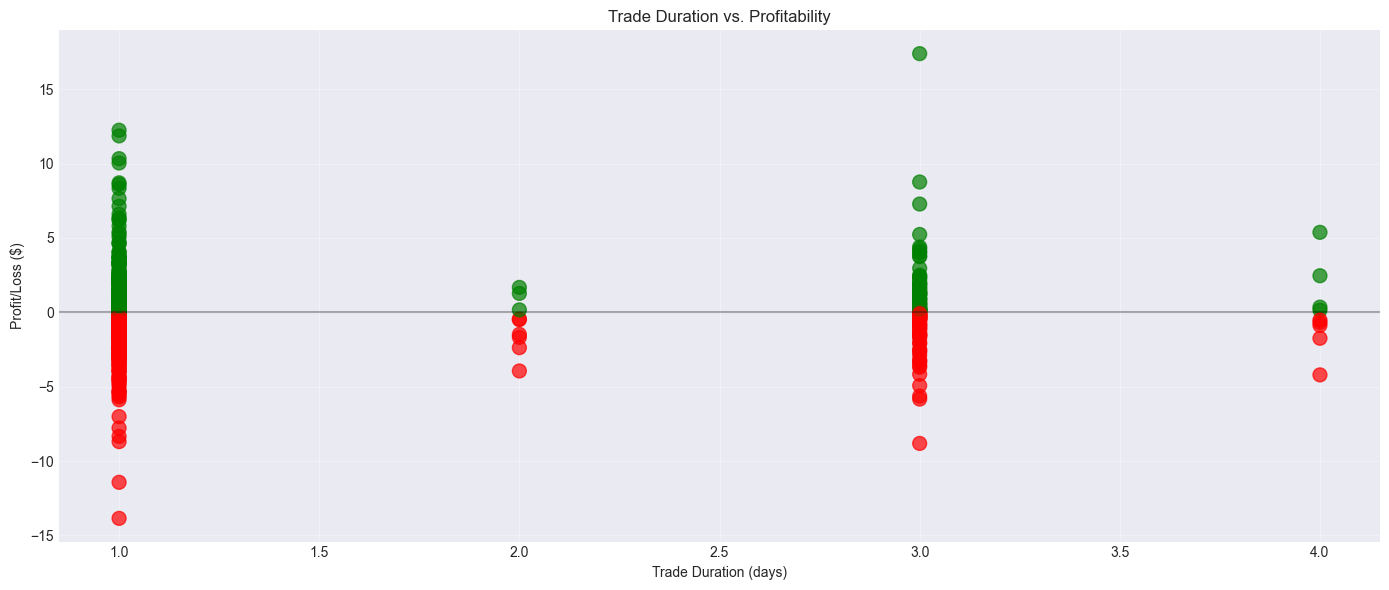

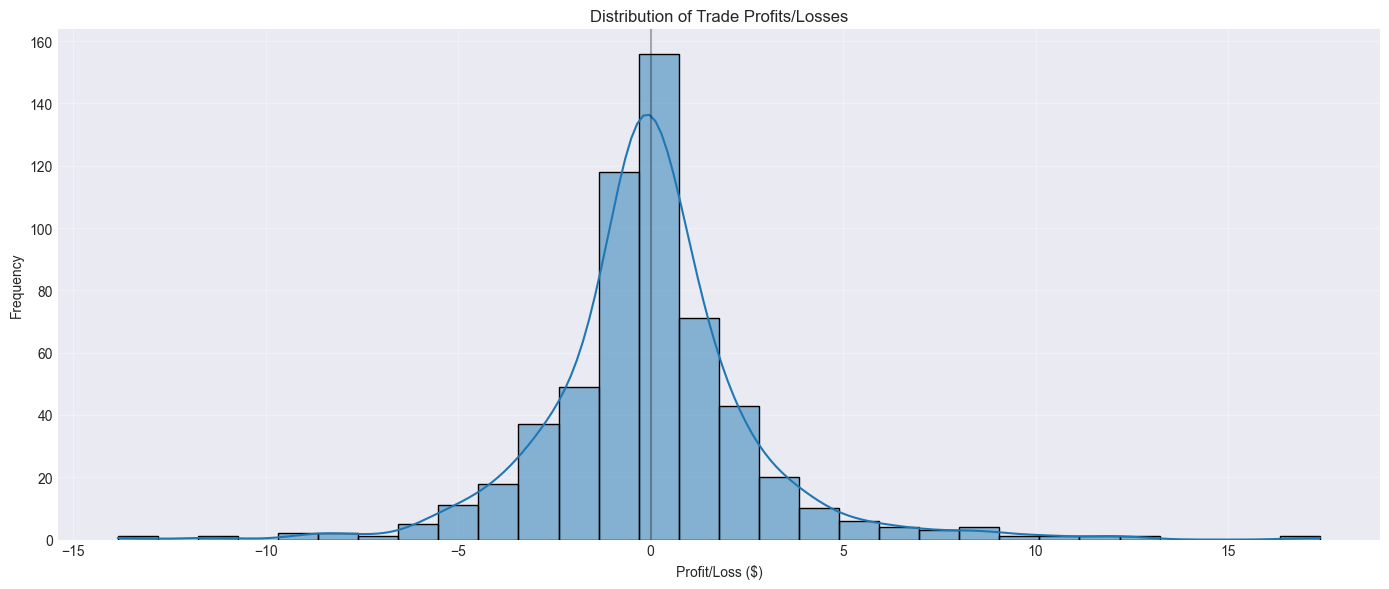

In [41]:
# Convert trades to DataFrame for analysis
if portfolio_results['trades']:
    trades_df = pd.DataFrame(portfolio_results['trades'])
    
    # Calculate trade durations
    trades_df['duration'] = pd.to_datetime(trades_df['exit_date']) - pd.to_datetime(trades_df['entry_date'])
    trades_df['duration_days'] = trades_df['duration'].dt.days
    
    # Summary statistics
    num_trades = len(trades_df)
    num_winning = sum(trades_df['pnl'] > 0)
    num_losing = sum(trades_df['pnl'] < 0)
    win_rate = num_winning / num_trades if num_trades > 0 else 0
    
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if num_winning > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if num_losing > 0 else 0
    
    profit_factor = abs(trades_df[trades_df['pnl'] > 0]['pnl'].sum() / 
                        trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if num_losing > 0 else float('inf')
    
    avg_duration = trades_df['duration_days'].mean()
    
    print("\nTrade Analysis:")
    print(f"Total Number of Trades: {num_trades}")
    print(f"Winning Trades: {num_winning} ({win_rate:.2%})")
    print(f"Losing Trades: {num_losing} ({1-win_rate:.2%})")
    print(f"Average Winning Trade: ${avg_win:.2f}")
    print(f"Average Losing Trade: ${avg_loss:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Average Trade Duration: {avg_duration:.1f} days")
    
    # Visualize trade durations and profitability
    plt.figure(figsize=(14, 6))
    plt.scatter(trades_df['duration_days'], trades_df['pnl'], 
                c=trades_df['pnl'].apply(lambda x: 'green' if x > 0 else 'red'),
                alpha=0.7, s=100)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Trade Duration vs. Profitability')
    plt.xlabel('Trade Duration (days)')
    plt.ylabel('Profit/Loss ($)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Distribution of trade profits
    plt.figure(figsize=(14, 6))
    sns.histplot(trades_df['pnl'], bins=30, kde=True)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Distribution of Trade Profits/Losses')
    plt.xlabel('Profit/Loss ($)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No trades were executed in the backtest period.")



In [42]:
# 9. Sensitivity analysis
logger.info("Performing sensitivity analysis")



[ 2025-05-11 20:17:24,096 ] 2 backtesting_notebook - INFO - Performing sensitivity analysis


In [43]:
# Parameters to test
entry_thresholds = [1.5, 2.0, 2.5, 3.0]
exit_thresholds = [0.0, 0.5, 1.0]


In [44]:
# Store sensitivity analysis results
sensitivity_results = []



In [45]:
# Run backtests with different parameters
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        # Update strategy parameters
        strategy_params_updated = strategy_params.copy()
        strategy_params_updated['entry_threshold'] = entry_threshold
        strategy_params_updated['exit_threshold'] = exit_threshold
        
        # Run backtest
        logger.info(f"Testing entry_threshold={entry_threshold}, exit_threshold={exit_threshold}")
        result = backtest_engine.run_backtest(
            price_data=processed_df,
            pairs=pairs_to_test,
            strategy_params=strategy_params_updated,
            start_date=start_date,
            end_date=end_date
        )
        
        # Store results
        sensitivity_results.append({
            'entry_threshold': entry_threshold,
            'exit_threshold': exit_threshold,
            'return': result['final_return'],
            'sharpe': result['sharpe_ratio'],
            'max_drawdown': result['max_drawdown'],
            'num_trades': len(result['trades'])
        })


[ 2025-05-11 20:17:37,038 ] 10 backtesting_notebook - INFO - Testing entry_threshold=1.5, exit_threshold=0.0
[ 2025-05-11 20:17:37,040 ] 141 BacktestEngine - INFO - Starting backtest with 5 pairs
[ 2025-05-11 20:17:37,040 ] 71 BacktestEngine - INFO - Preparing price data for backtesting
[ 2025-05-11 20:17:37,045 ] 89 BacktestEngine - INFO - Filtered price data for 10 tickers
[ 2025-05-11 20:17:37,057 ] 108 BacktestEngine - INFO - Prepared data for 8 tickers from 2020-01-03 00:00:00 to 2025-03-21 00:00:00
[ 2025-05-11 20:17:37,059 ] 44 PairsTrading - INFO - Initialized PairsTrading strategy with parameters: lookback_period=60, entry_threshold=1.5, exit_threshold=0.0, stop_loss=3.0, max_holding_period=20, position_size=0.02
[ 2025-05-11 20:17:37,077 ] 183 BacktestEngine - INFO - Backtest period: 2020-01-03 00:00:00 to 2025-03-21 00:00:00 (1311 days)
[ 2025-05-11 20:17:37,086 ] 76 PairsTrading - INFO - Calculated hedge ratio: 0.49459560645452777
[ 2025-05-11 20:17:37,122 ] 191 PairsTradin

In [46]:
# Convert to DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)


In [47]:
# Display results
print("\nSensitivity Analysis Results:")
display(sensitivity_df)



Sensitivity Analysis Results:


,entry_threshold,exit_threshold,return,sharpe,max_drawdown,num_trades
0,1.5,0.0,-0.013068,-3.929660,-0.013068,1177
1,1.5,0.5,-0.013068,-3.929660,-0.013068,1182
2,1.5,1.0,-0.013068,-3.929660,-0.013068,1182
3,2.0,0.0,-0.011698,-4.338286,-0.011698,567
4,2.0,0.5,-0.011698,-4.338286,-0.011698,567
5,2.0,1.0,-0.011698,-4.338286,-0.011698,567
6,2.5,0.0,-0.007811,-6.278656,-0.007811,253
7,2.5,0.5,-0.007811,-6.278656,-0.007811,253
8,2.5,1.0,-0.007811,-6.278656,-0.007811,253
9,3.0,0.0,-0.007342,-6.651997,-0.007342,107


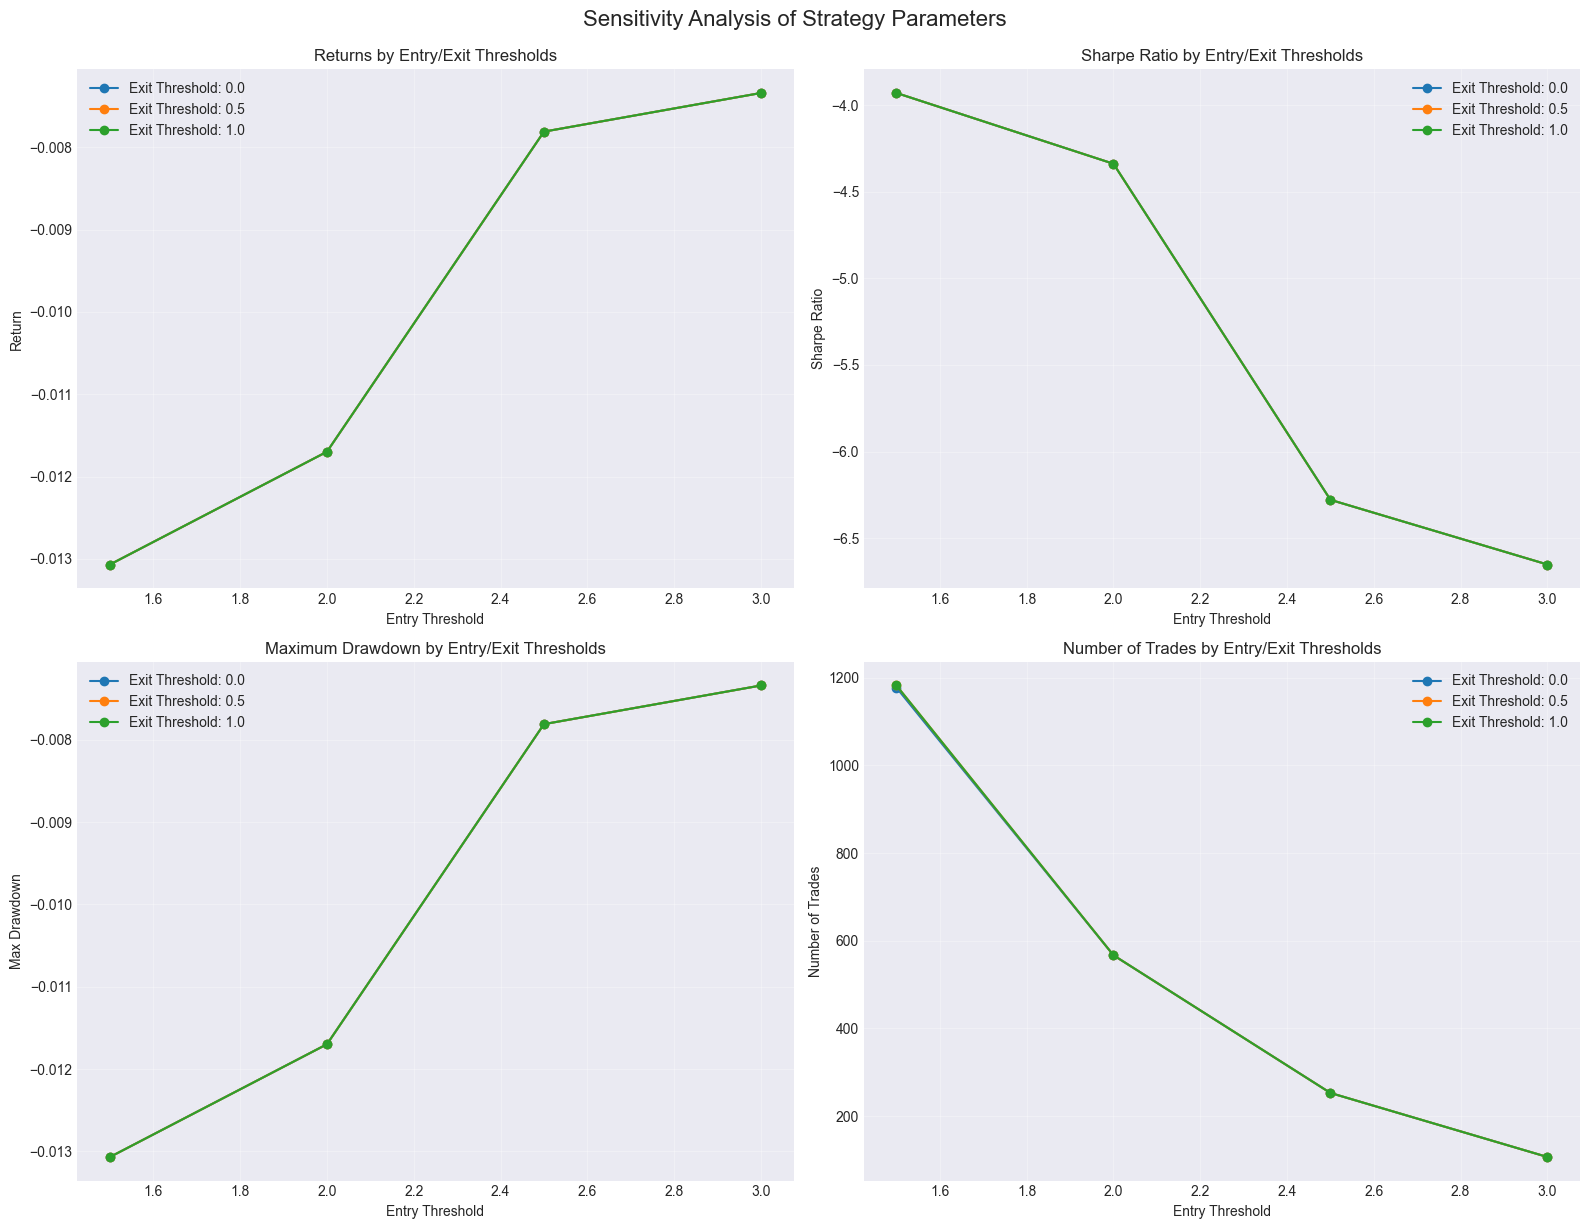

In [50]:
# Visualize sensitivity analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot returns by parameters
for exit_threshold in exit_thresholds:
    subset = sensitivity_df[sensitivity_df['exit_threshold'] == exit_threshold]
    ax1.plot(subset['entry_threshold'], subset['return'], 
             marker='o', label=f'Exit Threshold: {exit_threshold}')

ax1.set_title('Returns by Entry/Exit Thresholds')
ax1.set_xlabel('Entry Threshold')
ax1.set_ylabel('Return')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot Sharpe ratio by parameters
for exit_threshold in exit_thresholds:
    subset = sensitivity_df[sensitivity_df['exit_threshold'] == exit_threshold]
    ax2.plot(subset['entry_threshold'], subset['sharpe'], 
             marker='o', label=f'Exit Threshold: {exit_threshold}')

ax2.set_title('Sharpe Ratio by Entry/Exit Thresholds')
ax2.set_xlabel('Entry Threshold')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot max drawdown by parameters
for exit_threshold in exit_thresholds:
    subset = sensitivity_df[sensitivity_df['exit_threshold'] == exit_threshold]
    ax3.plot(subset['entry_threshold'], subset['max_drawdown'], 
             marker='o', label=f'Exit Threshold: {exit_threshold}')

ax3.set_title('Maximum Drawdown by Entry/Exit Thresholds')
ax3.set_xlabel('Entry Threshold')
ax3.set_ylabel('Max Drawdown')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot number of trades by parameters
for exit_threshold in exit_thresholds:
    subset = sensitivity_df[sensitivity_df['exit_threshold'] == exit_threshold]
    ax4.plot(subset['entry_threshold'], subset['num_trades'], 
             marker='o', label=f'Exit Threshold: {exit_threshold}')

ax4.set_title('Number of Trades by Entry/Exit Thresholds')
ax4.set_xlabel('Entry Threshold')
ax4.set_ylabel('Number of Trades')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.suptitle('Sensitivity Analysis of Strategy Parameters', fontsize=16, y=1.02)
plt.show()


In [51]:
# 10. Save backtest results
logger.info("Saving backtest results")



[ 2025-05-11 20:18:29,494 ] 2 backtesting_notebook - INFO - Saving backtest results


In [52]:
# Create directory if it doesn't exist
backtest_dir = os.path.join('..', 'data', 'processed', 'backtest_results')
os.makedirs(backtest_dir, exist_ok=True)


In [53]:
# Save portfolio performance metrics
portfolio_metrics_path = os.path.join(backtest_dir, "portfolio_performance.csv")
pd.DataFrame([portfolio_metrics]).to_csv(portfolio_metrics_path, index=False)
logger.info(f"Saved portfolio performance metrics to {portfolio_metrics_path}")


[ 2025-05-11 20:18:35,994 ] 4 backtesting_notebook - INFO - Saved portfolio performance metrics to ..\data\processed\backtest_results\portfolio_performance.csv


In [54]:
# Save sensitivity analysis results
sensitivity_path = os.path.join(backtest_dir, "sensitivity_analysis.csv")
sensitivity_df.to_csv(sensitivity_path, index=False)
logger.info(f"Saved sensitivity analysis to {sensitivity_path}")


[ 2025-05-11 20:18:39,721 ] 4 backtesting_notebook - INFO - Saved sensitivity analysis to ..\data\processed\backtest_results\sensitivity_analysis.csv


In [55]:
# Save trades
if portfolio_results['trades']:
    trades_path = os.path.join(backtest_dir, "trades.csv")
    trades_df.to_csv(trades_path, index=False)
    logger.info(f"Saved trades to {trades_path}")

print(f"Backtest results saved to {backtest_dir}")


[ 2025-05-11 20:18:43,994 ] 5 backtesting_notebook - INFO - Saved trades to ..\data\processed\backtest_results\trades.csv


Backtest results saved to ..\data\processed\backtest_results
